# Module Associations

**Created**: 20 October 2021

## Environment

In [64]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

if (!requireNamespace("ComplexHeatmap")) {
    install.package("ComplexHeatmap")
}

if (!requireNamespace("UpSetR")) {
    install.packages("UpSetR")
}

In [65]:
library(tidyverse)
library(RColorBrewer)
library(patchwork)
library(UpSetR)
library(ComplexHeatmap)
library(circlize)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

## Load Data

In [3]:
var.exp <- read.csv("~/gains_team282/nikhil/expression/gene_expression/variance.explained.csv")

est.cell.prop <- read.csv("~/gains_team282/nikhil/expression/gene_expression/estimates.eigengene.cell.proportion.association.csv", row.names=1)
est.xcell <- read.csv("~/gains_team282/nikhil/expression/gene_expression/estimates.eigengene.xcell.score.association.csv", row.names=1)
est.srsq <- read.csv("~/gains_team282/nikhil/expression/gene_expression/estimates.eigengene.srsq.association.csv", row.names=1)
est.outcome <- read.csv("~/gains_team282/nikhil/expression/gene_expression/estimates.eigengene.outcome.association.csv", row.names=1)
est.time.point <- read.csv("~/gains_team282/nikhil/expression/gene_expression/estimates.eigengene.time.point.association.csv", row.names=1)

In [4]:
xcell.info <- read.csv("04_Expression/data/xCell_Aran_et_al_Additional_File_1.csv")

In [5]:
head(xcell.info)

,Full.name,Cell.types,FANTOM5,ENCODE,Blueprint,IRIS,Novershtern,HPCA,X..of.sources,X..of.samples,Group,Subgroup,Parent.Child
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>
1,Monocytes,Monocytes,42,0,16,12,5,66,5,141,Non-lymphocytes,Myeloid,Parent
2,CD8+ T-cells,CD8+ T-cells,11,0,3,4,7,16,5,41,Lymphocytes,Lymphoid,Parent
3,NK cells,NK cells,3,0,3,15,6,5,5,32,Lymphocytes,Lymphoid,Parent
4,Macrophages,Macrophages,27,0,18,12,0,59,4,116,Non-lymphocytes,Myeloid,Parent
5,Endothelial cells,Endothelial cells,22,14,4,0,0,48,4,88,Non-Hematopoietic,Stroma,Parent
6,Dendritic cells,DC,4,0,1,6,0,45,4,56,Non-lymphocytes,Myeloid,Parent


## Create Combined Dataset

In [6]:
association.tbl <- dplyr::bind_rows(
  est.cell.prop, 
  est.xcell,
  est.srsq,
  est.outcome,
  est.time.point
)
rownames(association.tbl) <- NULL

write.csv(association.tbl, "~/gains_team282/nikhil/expression/gene_expression/estimates.all.csv", row.names=FALSE)

## Heatmap of Module Associations

In [7]:
cell.prop.data <- association.tbl %>%
    dplyr::mutate(Eigengene = factor(Eigengene, levels=paste0("ME_", 1:length(unique(Eigengene))))) %>%
    dplyr::filter(Association.Variable.Type == "Cell Proportion") %>%
    dplyr::mutate(Statistic = ifelse(Adjusted.P.Value < 1e-3, Statistic, 0)) %>%
    dplyr::select(Eigengene, Association.Variable, Statistic) %>%
    tidyr::spread(Association.Variable, Statistic)

cell.prop <- as.matrix(cell.prop.data[, c("Neutrophils", "Lymphocytes", "Monocytes")])
rownames(cell.prop) <- cell.prop.data$Eigengene

srsq.data <- association.tbl %>%
    dplyr::mutate(Eigengene = factor(Eigengene, levels=paste0("ME_", 1:length(unique(Eigengene))))) %>%
    dplyr::filter(Association.Variable.Type == "SRSq") %>%
    dplyr::mutate(Statistic = ifelse(Adjusted.P.Value < 1e-3, Statistic, 0)) %>%
    dplyr::select(Eigengene, SRSq=Statistic) %>%
    dplyr::arrange(Eigengene)

srsq <- as.matrix(srsq.data[, "SRSq", drop=F])
rownames(srsq) <- srsq.data$Eigengene

outcome.data <- association.tbl %>%
    dplyr::mutate(Eigengene = factor(Eigengene, levels=paste0("ME_", 1:length(unique(Eigengene))))) %>%
    dplyr::filter(Association.Variable.Type == "Outcome") %>%
    dplyr::mutate(Statistic = ifelse(Adjusted.P.Value < 1e-3, Statistic, 0)) %>%
    dplyr::select(Eigengene, Outcome=Statistic) %>%
    dplyr::arrange(Eigengene)

outcome <- as.matrix(outcome.data[, "Outcome", drop=F])
rownames(outcome) <- outcome.data$Eigengene

time.point.data <- association.tbl %>%
    dplyr::mutate(Eigengene = factor(Eigengene, levels=paste0("ME_", 1:length(unique(Eigengene))))) %>%
    dplyr::filter(Association.Variable.Type == "Time Point") %>%
    dplyr::mutate(Statistic = ifelse(Adjusted.P.Value < 1e-3, Statistic, 0)) %>%
    dplyr::select(Eigengene, Time.Point=Statistic) %>%
    dplyr::arrange(Eigengene)

time.point <- as.matrix(time.point.data[, "Time.Point", drop=F])
rownames(time.point) <- time.point.data$Eigengene

In [8]:
options(repr.plot.width=5, repr.plot.height=20)

col.fun.rho <- colorRamp2(seq(-1, 1, length.out=11), brewer.pal("RdBu", n=11))
col.fun.beta <- colorRamp2(seq(-20, 20, length.out=11), brewer.pal("RdBu", n=11))
col.fun.ges <- colorRamp2(seq(0, 0.25, length.out=9), brewer.pal("Reds", n=9))

h1 <- Heatmap(
    cell.prop, name="Rho1",
    col=col.fun.rho,
    rect_gp=gpar(col="white", lwd=2),
    cluster_rows=F, cluster_columns=F
)

h2 <- Heatmap(
    srsq, name="Rho2",
    col=col.fun.rho,
    rect_gp=gpar(col="white", lwd=2)
)

h3 <- Heatmap(
    outcome, name="Beta",
    col=col.fun.beta,
    rect_gp=gpar(col="white", lwd=2)
)

h4 <- Heatmap(
    time.point, name="GES",
    col=col.fun.ges,
    rect_gp=gpar(col="white", lwd=2)
)

svg("04_Expression/results/module_association_heatmap.svg", width=5, height=20)
h1 + h2 + h3 + h4
dev.off()

png 
  2

![Heatmap](../results/module_association_heatmap.svg)

## Heatmap of Module Association with xCell Scores

In [9]:
xcell.data <- association.tbl %>%
    dplyr::mutate(Eigengene = factor(Eigengene, levels=paste0("ME_", 1:length(unique(Eigengene))))) %>%
    dplyr::filter(Association.Variable.Type == "xCell Score") %>%
    merge(., xcell.info, by.x="Association.Variable", by.y="Cell.types") %>%
    dplyr::filter(Subgroup %in% c("HSC", "Lymphoid", "Myeloid")) %>%
    dplyr::mutate(Statistic = ifelse(Adjusted.P.Value < 1e-4, Statistic, 0)) %>%
    dplyr::select(Eigengene, Association.Variable, Statistic) %>%
    tidyr::spread(Association.Variable, Statistic)

xcell <- as.matrix(xcell.data[, -1])
rownames(xcell) <- xcell.data$Eigengene

In [10]:
options(repr.plot.width=16, repr.plot.height=20)

col.fun.rho <- colorRamp2(seq(-1, 1, length.out=11), brewer.pal("RdBu", n=11))

subgroups <- xcell.info$Subgroup
names(subgroups) <- xcell.info$Cell.type

svg("04_Expression/results/module_xcell_association_heatmap.svg", width=14, height=20)
Heatmap(
    xcell, name="Rho",
    col=col.fun.rho,
    column_split=subgroups[colnames(xcell)],
    column_gap = unit(5, "mm"),
    rect_gp=gpar(col="white", lwd=2),
    cluster_rows=F, cluster_columns=F
)
dev.off()

png 
  2

![Heatmap](../results/module_xcell_association_heatmap.svg)

## Identify Shared Association Sets

In [11]:
association.sds <- association.tbl %>%
    dplyr::group_by(Association.Variable.Type) %>%
    dplyr::summarize(Mean=mean(Statistic), SD=sd(Statistic))

png 
  2

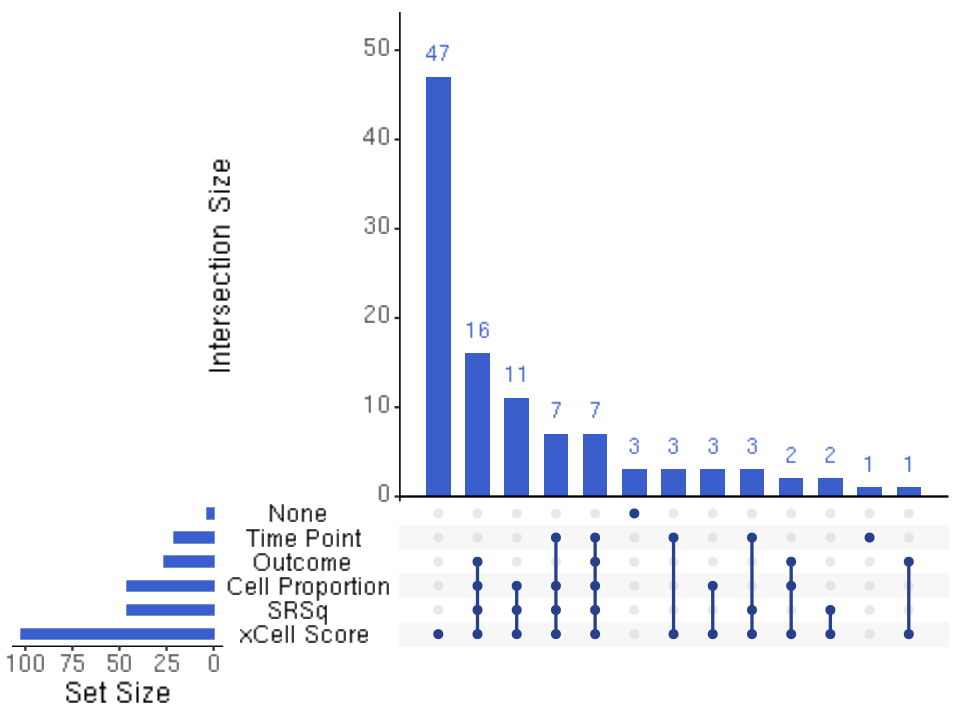

In [12]:
plot.data <- association.tbl %>%
  merge(., association.sds, by="Association.Variable.Type") %>%
  dplyr::filter(Adjusted.P.Value < 0.05, abs(Statistic - Mean) > SD)

plot.data <- split(plot.data, plot.data$Association.Variable.Type) %>%
  lapply(., function(x) unique(x[,"Eigengene"]))

plot.data[["None"]] <- setdiff(var.exp$Module, unique(unlist(plot.data)))

svg("04_Expression/results/eigengene_association_overlap.svg", width=8, height=6)
upset(
  fromList(plot.data), order.by="freq",
  matrix.color="royalblue4", main.bar.color="royalblue3", sets.bar.color="royalblue3",
  text.scale=2, nsets=6
)
dev.off()

options(repr.plot.width=8, repr.plot.height=6)
upset(
  fromList(plot.data), order.by="freq",
  matrix.color="royalblue4", main.bar.color="royalblue3", sets.bar.color="royalblue3",
  text.scale=2, nsets=6
)

In [13]:
# Identify Module Association Sets
modules <- Reduce(union, plot.data)

module.association.mtx <- lapply(modules, function(module.name) {
  return(sapply(plot.data, function(set) module.name %in% set))
}) %>%
  do.call(rbind, .) %>%
  as.data.frame()
rownames(module.association.mtx) <- modules

module.association.mtx %>%
    dplyr::filter(`Cell Proportion` & !Outcome & !SRSq & !`Time Point`)

,Cell Proportion,Outcome,SRSq,Time Point,xCell Score,None
,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
ME_106,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE
ME_66,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE
ME_64,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE
